In [1]:
!pip install tensorflow tensorflow-io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 41.0 MB/s eta 0:00:00


In [9]:
import os
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import subprocess
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from google.colab import drive

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization, Input, Normalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

# Authenticate Google Drice

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# DEVELOP & TRAIN MODEL

Setup Constants

In [ ]:
# data dir
data_dir = "gdrive/MyDrive/Bangkit Capstone/Colab Files/Snoring Dataset"
model_file = "gdrive/MyDrive/Bangkit Capstone/Colab Files/Snoring-Detection-Model-44100.hdf5"

# data constants
epochs = 20
batch_size = 64
input_shape = (343, 129, 1)

<ipython-input-15-ac2b36cbd42e>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_data = read(SNORING_FILE)


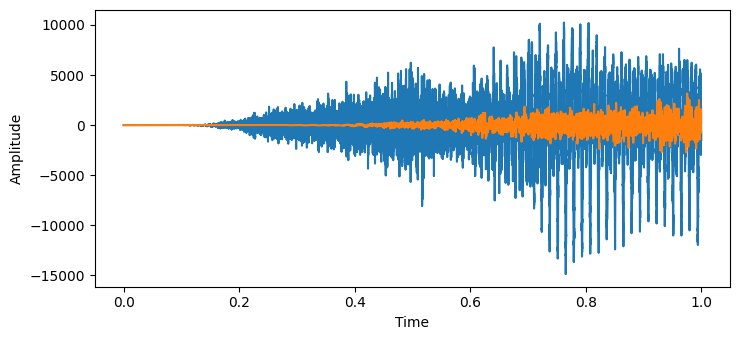

In [ ]:
SNORING_FILE = os.path.join('gdrive/MyDrive/Bangkit Capstone/Colab Files/Snoring Dataset/1','1_0.wav')
## plot 44100Hz to time
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
input_data = read(SNORING_FILE)
x_1 = np.linspace(0, 1, 16000)
x_2 = np.linspace(0, 1, 44100)

audio = input_data[1]
plt.plot(x_2,audio[0:44100])
plt.plot(x_1,audio[0:16000])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

Load dataset



In [ ]:
# Load audio files manually
file_labels = []
file_paths = []
labels = []

for label_name in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label_name)
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            file_labels.append((file_path, label_name))

# Shuffle and assign to corresponding list
random.shuffle(file_labels)
for (file_name, label) in file_labels:
    file_paths.append(file_name)
    labels.append(label)

# Convert labels to binary values
labels = np.array(labels)
label_names = np.unique(labels)
label_to_index = dict(zip(label_names, range(len(label_names))))
labels = np.array([label_to_index[label] for label in labels])

# Create TensorFlow Dataset
files_dataset = tf.data.Dataset.from_tensor_slices(file_paths)
labels_dataset = tf.data.Dataset.from_tensor_slices(labels)

audio_dataset = tf.data.Dataset.zip((files_dataset, labels_dataset))

Preprocess

In [ ]:
# Remove unused dimension
def load_audio(file_path, label):
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

audio_dataset = audio_dataset.map(load_audio)

# Determine the maximum audio length
max_length = 0
for audio, _ in audio_dataset:
    length = tf.shape(audio)[0]
    if length > max_length:
        max_length = length

# Pad or truncate audio samples to the maximum length
def pad_or_truncate_audio(audio, label):
    audio = tf.pad(audio, paddings=[[0, max_length - tf.shape(audio)[0]]], constant_values=0)
    audio = audio[:max_length]
    return audio, label

audio_dataset = audio_dataset.map(pad_or_truncate_audio)

# Change shape with fourier transform
def preprocess(wav, labels):
    wav = wav[:44100] # use 44.1 kHz format
    # zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    # wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, labels

audio_dataset = audio_dataset.map(preprocess)

Split to train and validation

In [ ]:
train_data = audio_dataset.take(int(0.8 * len(file_paths)))
val_data = audio_dataset.skip(int(0.8 * len(file_paths)))

Batch data

In [ ]:
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

train_data.element_spec

(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Build model & compile

In [ ]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
    Conv2D(32, (3,3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer='Adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'], 
    )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 341, 127, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 339, 125, 32)      18464     
                                                                 
 flatten (Flatten)           (None, 1356000)           0         
                                                                 
 dense (Dense)               (None, 128)               173568128 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 173,587,361
Trainable params: 173,587,361
Non-trainable params: 0
_________________________________________________________________


Train model

In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

def train_model(model, initial_epoch=0, max_epochs=20):
    start_time = time.time()

    history = model.fit(x=train_data,
                validation_data=val_data,
                batch_size=batch_size,
                epochs=max_epochs,
                initial_epoch=initial_epoch)
    
    score = model.evaluate(val_data, verbose=0)
    print('Test loss: {}'.format(score[0]))
    print('Test accuracy: {}'.format(score[1]))

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time)))

    return history

history = train_model(model, max_epochs=epochs)

Epoch 1/20
13/13 [==============================] - 281s 22s/step - loss: 0.8851 - accuracy: 0.6787 - val_loss: 0.3814 - val_accuracy: 0.8300
Epoch 2/20
13/13 [==============================] - 264s 20s/step - loss: 0.3106 - accuracy: 0.9150 - val_loss: 0.2377 - val_accuracy: 0.8900
Epoch 3/20
13/13 [==============================] - 282s 22s/step - loss: 0.1464 - accuracy: 0.9638 - val_loss: 0.1469 - val_accuracy: 0.9250
Epoch 4/20
13/13 [==============================] - 266s 20s/step - loss: 0.0785 - accuracy: 0.9688 - val_loss: 0.1309 - val_accuracy: 0.9350
Epoch 5/20
13/13 [==============================] - 265s 20s/step - loss: 0.0524 - accuracy: 0.9875 - val_loss: 0.1260 - val_accuracy: 0.9600
Epoch 6/20
13/13 [==============================] - 255s 20s/step - loss: 0.0249 - accuracy: 0.9975 - val_loss: 0.2862 - val_accuracy: 0.9250
Epoch 7/20
13/13 [==============================] - 253s 20s/step - loss: 0.0920 - accuracy: 0.9775 - val_loss: 0.1597 - val_accuracy: 0.9400
Epoch 

Plot training history

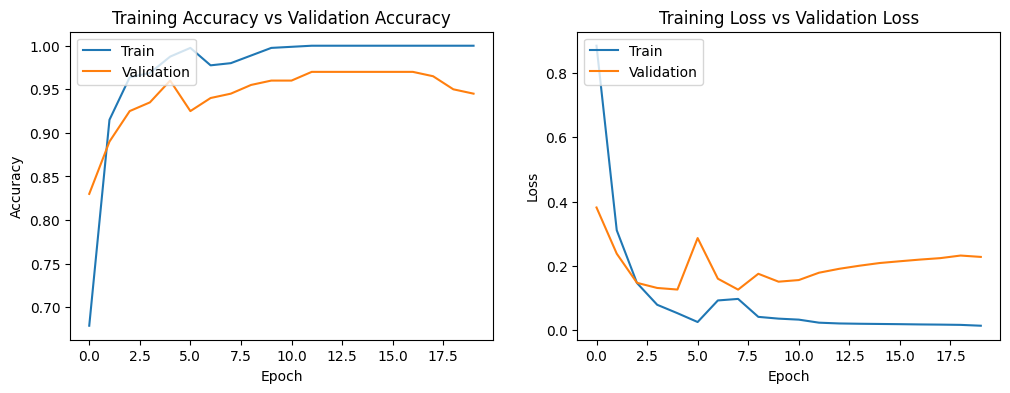

In [ ]:
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

Save model

In [ ]:
model.save(model_file)

# PREDICT REAL WORLD DATA

Setup constants

In [10]:
# model_path = "gdrive/MyDrive/Bangkit Capstone/Colab Files/Snoring-Detection-Model-44100.hdf5"
model_path = "/content/gdrive/MyDrive/Bangkit Capstone/Colab Files/Snoring-Detection-Model-44100.hdf5"
# data_path = "gdrive/MyDrive/Bangkit Capstone/Colab Files/fat guy snoring-20s.wav"
data_path = "/content/gdrive/MyDrive/Bangkit Capstone/Colab Files/fat guy snoring.aac"
data_path_wav = "/content/gdrive/MyDrive/Bangkit Capstone/Colab Files/audio.wav"

Load model

In [5]:
model = load_model(model_path)
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fa431c73e50>>

Load and preprocess real world data

In [13]:
# Load audio
def load_audio_data(file_path, duration=1):
    subprocess.run(["ffmpeg", "-i", file_path, "-acodec", "pcm_s16le", "-ar", "44100", data_path_wav])
    audio = tf.io.read_file(data_path_wav)
    audio, sample_rate = tf.audio.decode_wav(audio, desired_channels=-1)

    # Divide for each second
    chunk_size = int(duration * sample_rate)
    audio_chunks = []
    for i in range(0, audio.shape[0], chunk_size):
        chunk = audio[i:i+chunk_size]

        # Add zero padding if chunk size is different
        if chunk.shape[0] != chunk_size:
            zero_padding = tf.zeros([chunk_size - chunk.shape[0], 1], dtype=tf.float32)
            chunk = tf.concat([zero_padding, chunk],0)
        
        audio_chunks.append(chunk)

    audio_chunks = tf.data.Dataset.from_tensor_slices(audio_chunks)
    audio_chunks = audio_chunks.map(lambda x: tf.squeeze(x, axis=-1))
    return audio_chunks


# Change shape with fourier transform
def preprocess_audio(wav):
    wav = wav[:44100]
    # zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    # wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

audio_data = load_audio_data(data_path)
audio_data = audio_data.map(preprocess_audio)

audio_data.element_spec

TypeError: ignored

Predict data

In [ ]:
print(len(audio_data))

21


In [ ]:
audio_data_batch = audio_data.batch(1)
start_time = time.time()
result = model.predict(audio_data_batch)
print("Audio files predicted:", len(result))

count = 0
for el in result:
    if el >= 0.5:
        count += 1
print("Snore detected:", count)
print("Elapsed time:", time.time()-start_time)

21/21 [==============================] - 6s 256ms/step
Audio files predicted: 21
Snore detected: 13
Elapsed time: 5.914085865020752


In [ ]:
count = 0
for el in result:
    if el >= 0.99:
        count += 1
print("Snore detected:", count)
print(result)

Snore detected: 12
[[9.6792439e-03]
 [1.4181270e-01]
 [9.9999559e-01]
 [1.9870026e-03]
 [9.9252343e-01]
 [9.9981570e-01]
 [3.4829194e-03]
 [1.0000000e+00]
 [9.9517870e-01]
 [4.2275502e-04]
 [9.9999982e-01]
 [9.9977529e-01]
 [5.2024340e-03]
 [9.9960923e-01]
 [9.9973434e-01]
 [1.5484646e-03]
 [1.0000000e+00]
 [9.9677628e-01]
 [5.3662956e-01]
 [1.0000000e+00]
 [2.4351576e-02]]
